# Synthetic control with `pymc` models

In [1]:
import arviz as az

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = cp.load_data("sc")
treatment_time = 70

## Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

In [4]:
df.head()

,a,b,c,d,e,f,g,counterfactual,causal effect,actual
0,0.793234,1.277264,-0.055407,-0.791535,1.075170,0.817384,-2.607528,0.144888,-0.0,0.398287
1,1.841898,1.185068,-0.221424,-1.430772,1.078303,0.890110,-3.108099,0.601862,-0.0,0.491644
2,2.867102,1.922957,-0.153303,-1.429027,1.432057,1.455499,-3.149104,1.060285,-0.0,1.232330
3,2.816255,2.424558,0.252894,-1.260527,1.938960,2.088586,-3.563201,1.520801,-0.0,1.672995
4,3.865208,2.358650,0.311572,-2.393438,1.977716,2.752152,-3.515991,1.983661,-0.0,1.775940


In [5]:
result = cp.SyntheticControl(
    df,
    treatment_time,
    control_units=["a", "b", "c", "d", "e", "f", "g"],
    treated_units=["actual"],
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


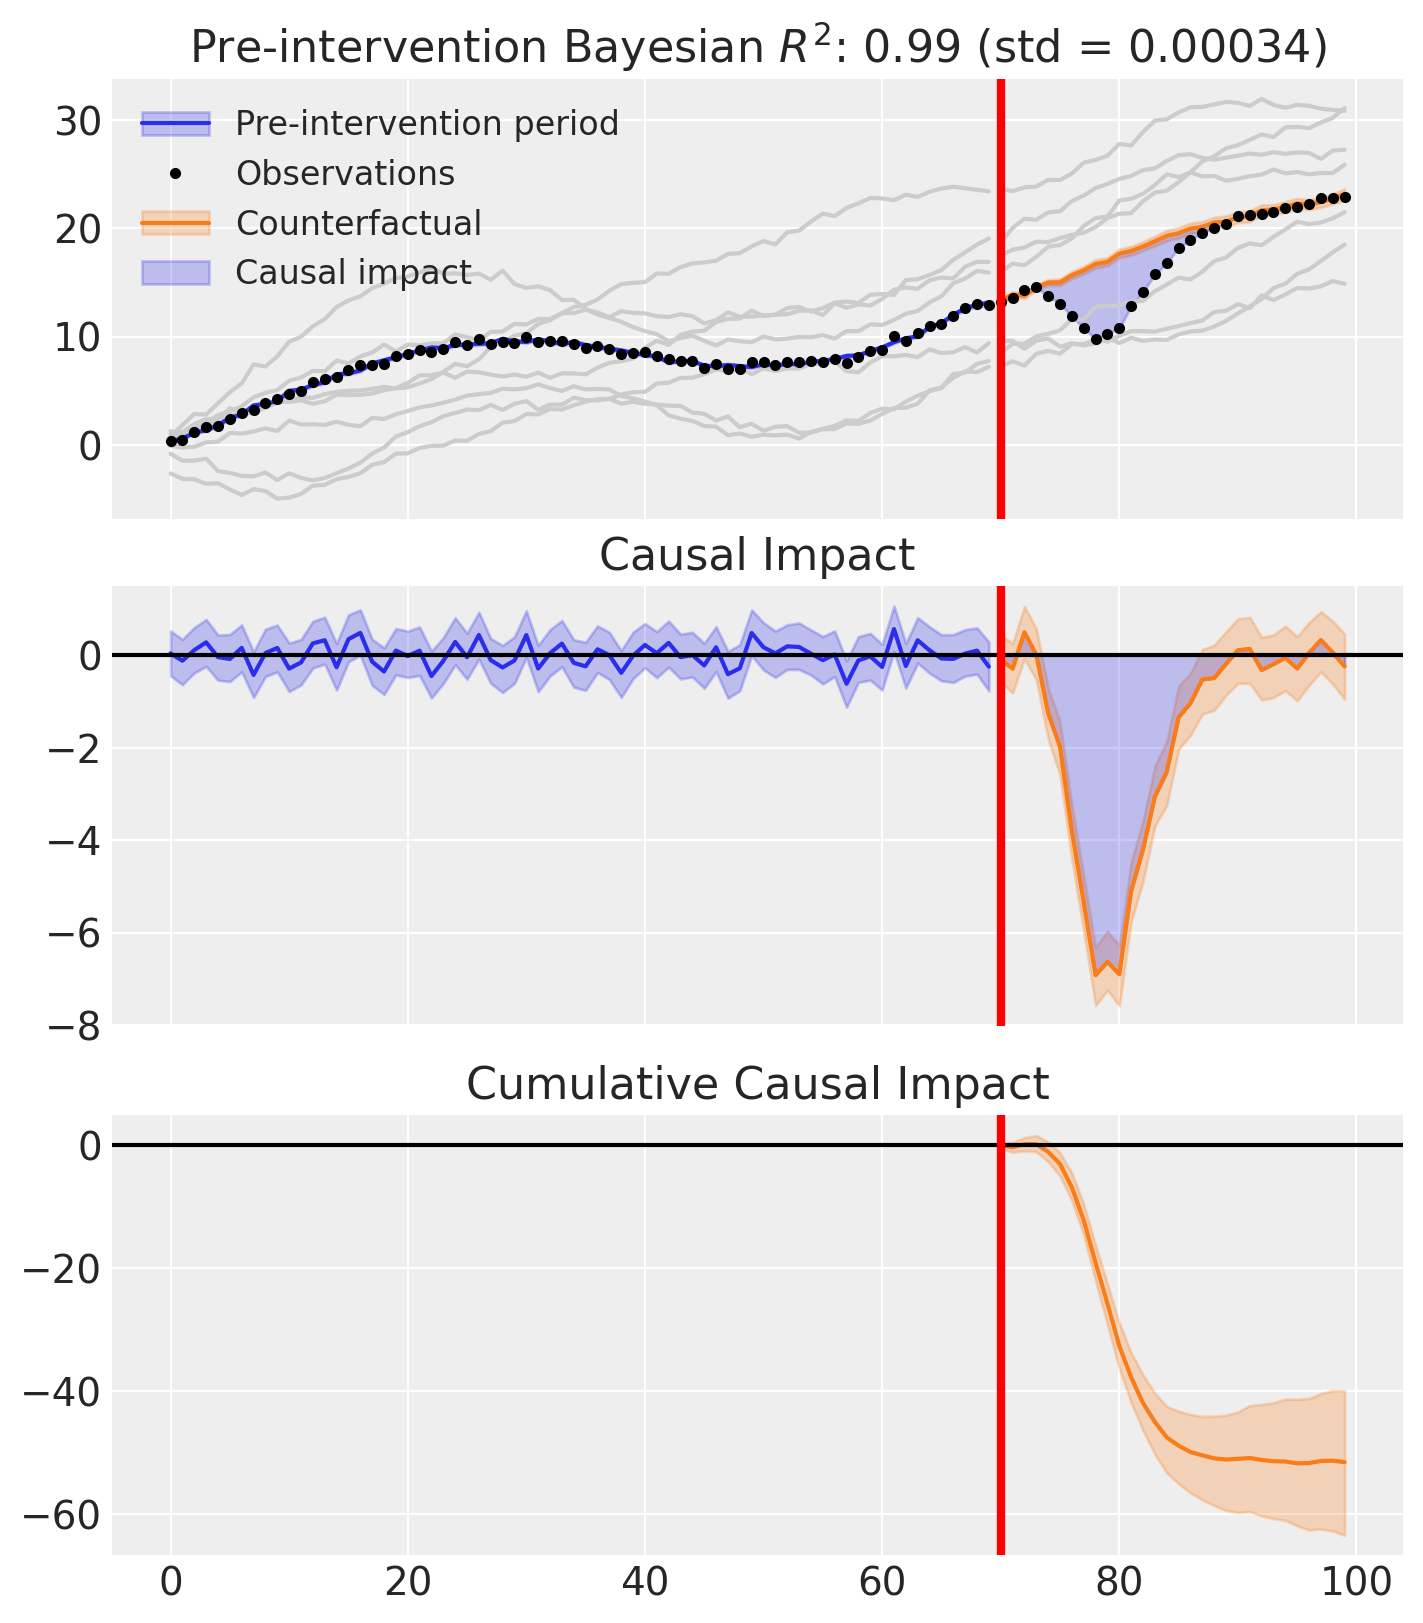

In [6]:
fig, ax = result.plot(plot_predictors=True)

In [7]:
result.summary()

================================SyntheticControl================================
Control units: ['a', 'b', 'c', 'd', 'e', 'f', 'g']
Treated unit: actual
Model coefficients:
    a      0.33, 94% HDI [0.3, 0.38]
    b      0.05, 94% HDI [0.011, 0.089]
    c      0.3, 94% HDI [0.26, 0.35]
    d      0.054, 94% HDI [0.01, 0.1]
    e      0.024, 94% HDI [0.001, 0.065]
    f      0.2, 94% HDI [0.11, 0.26]
    g      0.038, 94% HDI [0.0028, 0.087]
    sigma  0.26, 94% HDI [0.22, 0.31]


As well as the model coefficients, we might be interested in the average causal impact and average cumulative causal impact.

In [8]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[actual],-1.72,0.216,-2.116,-1.333,0.006,0.003,1213.0,1704.0,1.01


:::{Warning}

Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [9]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[actual],-51.597,6.471,-63.492,-39.988,0.185,0.105,1213.0,1704.0,1.01
